In [1]:
%matplotlib inline

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import pickle
import scipy as sp
import mpmath
import seaborn as sns
from matplotlib.lines import Line2D


import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

In [3]:
import os, sys
base_path = os.path.join('/home/apizzuto/Nova/scripts/','')
sys.path.append(base_path)
from config import *
from Novae import Nova

In [4]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_gamma_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [5]:
df = pd.read_pickle('/home/apizzuto/Nova/Novae_details_with_seasons.csv')
df = df.sort_values('Start Time (gamma ray)')
during_greco = (df['Start Time (gamma ray)'] > greco_ana.mjd_min) & (df['Start Time (gamma ray)'] + df['Duration (gamma ray)'] < greco_ana.mjd_max)
df = df[during_greco]

In [6]:
names = np.array([name.replace(' ', '_') for name in df['Name']])

ra_degs, dec_degs = df['RA (Deg)'], df['Dec. (Deg)']
ras = np.radians(ra_degs)
decs = np.radians(dec_degs)
sindecs = np.sin(decs)

mjds = df['Start Time (gamma ray)']
max_time_window = 10.
delta_ts = df['Duration (gamma ray)']
delta_ts = np.minimum(delta_ts, np.ones_like(delta_ts)*max_time_window)

In [7]:
trials_dir = cy.utils.ensure_dir('/data/user/apizzuto/Nova/analysis_trials/learning_csky/')
bg_dir = cy.utils.ensure_dir('{}/bg'.format(trials_dir))

def do_background_trials(name, ra, dec, mjd, delta_t, N=1000, seed=0):
    # get trial runner
    src = cy.sources(ra, dec, mjd=mjd, sigma_t=0., t_100=delta_t)
    tr = cy.get_trial_runner(conf, src=src, ana=greco_ana)
    # run trials
    trials = tr.get_many_fits(N, seed=seed, logging=False)
    # save to disk
    dir = cy.utils.ensure_dir(f"{bg_dir}/nova/{name}")
    filename = '{}/trials__N_{:06d}_seed_{:04d}.npy'.format(dir, N, seed)
    print('->', filename)
    # notice: trials.as_array is a numpy structured array, not a cy.utils.Arrays
    np.save(filename, trials.as_array)

In [8]:
do_background_trials('test_nova', 0.0, 0.0, 57000., 1., N=100)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/test_nova/trials__N_000100_seed_0000.npy


In [9]:
os.remove('/data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/test_nova/trials__N_000100_seed_0000.npy')

In [10]:
n_jobs = 2
N = 500

# in real life you should keep track of compute time within your jobs
for name, ra, dec, mjd, delta_t in zip(names, ras, decs, mjds, delta_ts):
    for seed in range(n_jobs):
        do_background_trials(name, ra, dec, mjd, delta_t, N=N, seed=seed)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V1324_Sco_2012/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V1324_Sco_2012/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V959_Mon_2012/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V959_Mon_2012/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V339_Del_2013/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V339_Del_2013/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V1369_Cen_2013/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V1369_Cen_2013/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/nova/V1535_Sco/trials__N_000500_seed_0

In [8]:
def ndarray_to_Chi2TSD(trials):
    return cy.dists.Chi2TSD(cy.utils.Arrays(trials))

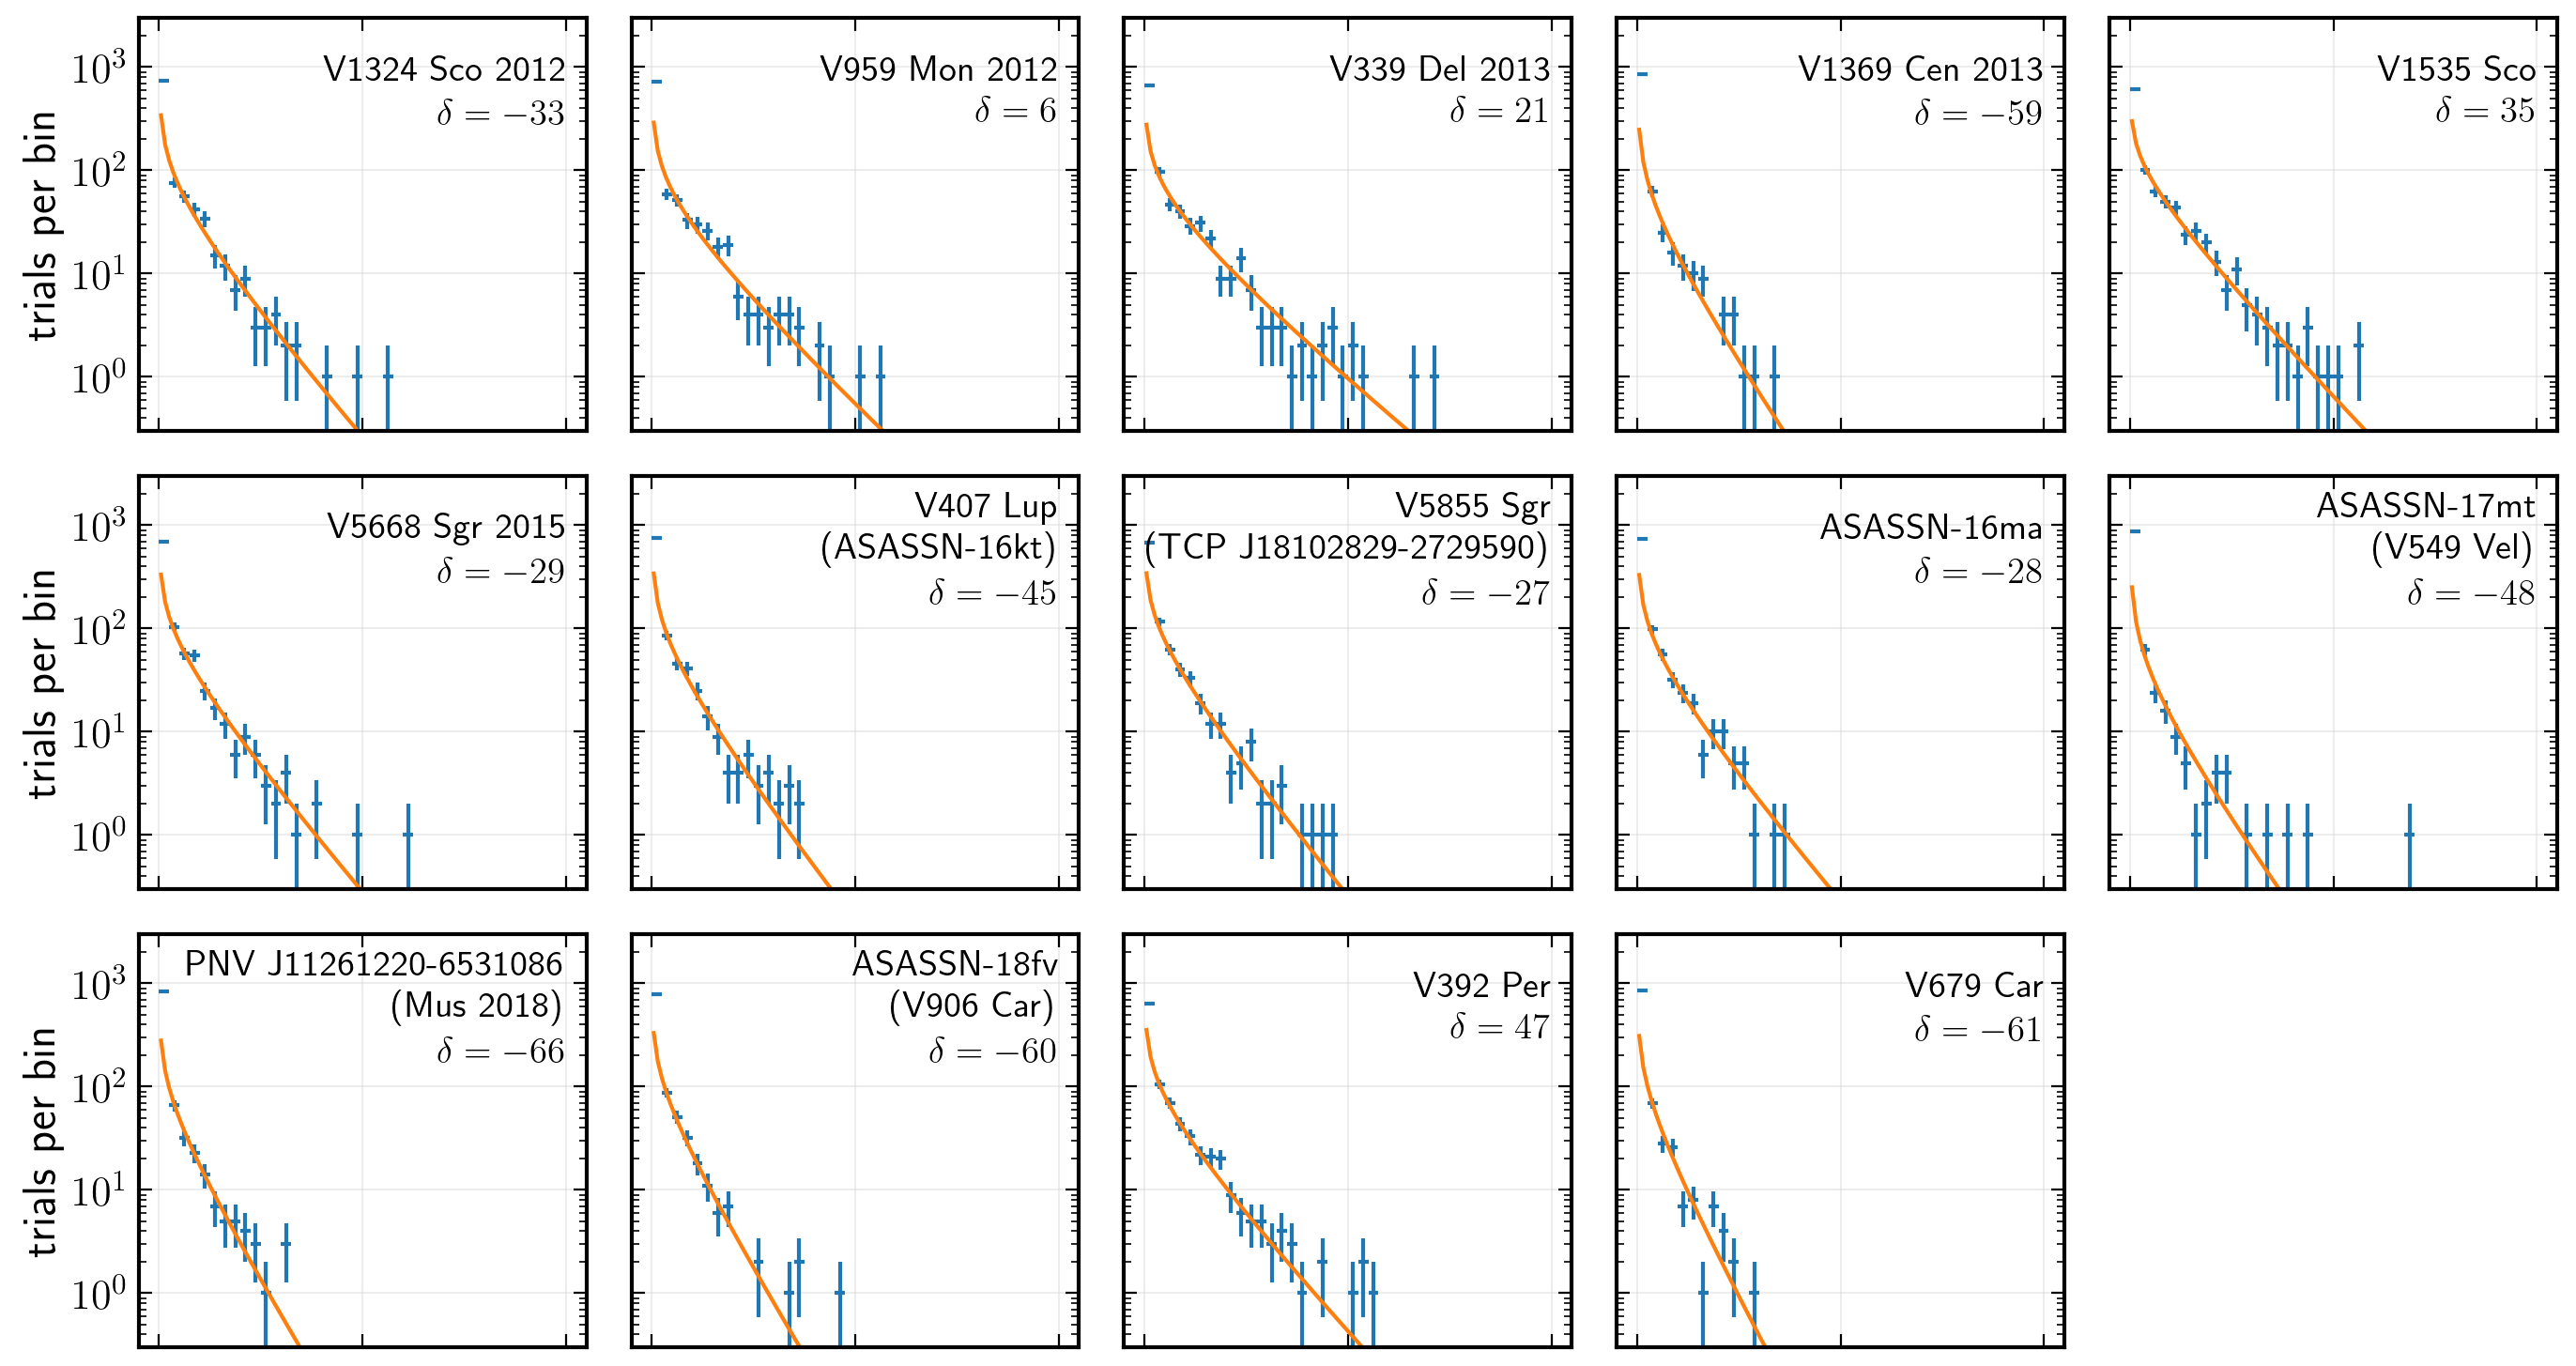

In [9]:
bg = cy.bk.get_all(
        # disk location
        '{}/nova'.format(bg_dir),
        # filename pattern
        'trials*npy',
        # how to combine items within each directory
        merge=np.concatenate,
        # what to do with items after merge
        post_convert=ndarray_to_Chi2TSD)

# just choose enough nrow x ncol to fit the whole grid
nrow, ncol = 4, 5
fig, aaxs = plt.subplots(nrow, ncol, figsize=(14,10), 
                         sharex=True, sharey=True, dpi=200)

axs = np.ravel(aaxs)
# keep track of which ax's we already used
used_axs = []
for (i, name) in enumerate(names):
    ax = axs[i]
    # plot histogram
    b = bg[name]
    h = b.get_hist(bins=40, range=(0, 20))
    hl.plot1d(ax, h, crosses=True)
    # plot chi2 fit to nonzero values
    norm = h.integrate().values
    ts = np.linspace(.1, h.range[0][1], 100)
    ax.plot(ts, norm * b.pdf(ts))
    # set limits and label dec
    ax.semilogy(nonposy='clip')
    ax.set_ylim(.3, 3e3)
    ax.text(20, 6e2, name.replace('_', ' ').replace(' (', '\n(') + '\n' + r'$\delta={:.0f}$'.format(dec_degs.values[i]), 
            ha='right', va='center', fontsize=14)
    used_axs.append(ax)
# hide unused ax's
for ax in axs:
    if ax not in used_axs:
        ax.set_visible(False)
# add x and y labels
for ax in aaxs[-1]:
    if ax in used_axs:
        ax.set_xlabel(r'$\sin(\delta)$')
for ax in aaxs[:,0]:
    ax.set_ylabel(r'trials per bin')
plt.tight_layout()

In [10]:
sig_dir = cy.utils.ensure_dir('{}/sig'.format(trials_dir))

def do_signal_trials(name, ra, dec, mjd, delta_t, n_sig, N=1000, seed=0):
    # get trial runner
    src = cy.sources(ra, dec, mjd=mjd, sigma_t=0., t_100=delta_t)
    tr = cy.get_trial_runner(conf, src=src, ana=greco_ana)
    # run trials
    trials = tr.get_many_fits(N, n_sig, seed=seed, logging=False)
    # save to disk
    dir = cy.utils.ensure_dir('{}/nova/{}/nsig/{:05.1f}'.format(sig_dir, name, n_sig))
    filename = '{}/trials__N_{:06d}_seed_{:04d}.npy'.format(dir, N, seed)
    print('->', filename)
    # notice: trials.as_array is a numpy structured array, not a cy.utils.Arrays
    np.save(filename, trials.as_array)

In [12]:
cy.CONF['mp_cpus'] = 10

In [13]:
N = 100
n_jobs = 2
n_sigs = np.r_[2:10:2, 10:30.1:5]

for name, ra, dec, mjd, delta_t in zip(names, ras, decs, mjds, delta_ts):
    for n_sig in n_sigs:
        for seed in range(n_jobs):
            do_signal_trials(name, ra, dec, mjd, delta_t, n_sig, N=N, seed=seed)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/002.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/002.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/004.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/004.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/006.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/006.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/008.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1324_Sco_2012/nsig/008.0/trials__N_000100_seed_0001.npy


-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/020.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/020.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/025.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/025.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/030.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1369_Cen_2013/nsig/030.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1535_Sco/nsig/002.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V1535_Sco/nsig/002.0/trials__N_000100_seed_0001.npy
-> /data/u

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/006.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/008.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/008.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/010.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/010.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/015.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/V5855_Sgr_(TCP_J18102829-2729590)/nsig/015.0/trials__N_000100_seed_0

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/PNV_J11261220-6531086__(Mus_2018)/nsig/020.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/PNV_J11261220-6531086__(Mus_2018)/nsig/025.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/PNV_J11261220-6531086__(Mus_2018)/nsig/025.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/PNV_J11261220-6531086__(Mus_2018)/nsig/030.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/PNV_J11261220-6531086__(Mus_2018)/nsig/030.0/trials__N_000100_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/ASASSN-18fv_(V906_Car)/nsig/002.0/trials__N_000100_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/nova/ASASSN-18fv_(V906_Car)/nsig/002.0/trials__N_000100_seed_0001.npy
-> /data/user/

In [1]:
sig = cy.bk.get_all(sig_dir, 'trials*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)

NameError: name 'cy' is not defined

In [15]:
trs = {name: cy.get_trial_runner(conf, src=cy.sources(ra, dec, mjd=mjd, sigma_t=0., t_100=delta_t), ana=greco_ana) for name, ra, dec, mjd, delta_t in zip(names, ras, decs, mjds, delta_ts)}


In [16]:
@np.vectorize
def find_n_sig(name, beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'nova', name, 'nsig')
    b = cy.bk.get_best(bg, name)
    tr = cy.bk.get_best(trs, name)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # include background trials in calculation
    trials = {0: b.trials}
    trials.update(sig_trials)
    # get number of signal events
    # (arguments prevent additional trials from being run)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=100, unit=1e3)

In [17]:
fluxs_sens = find_n_sig(names)
fluxs_disc = find_n_sig(names, beta=0.5, nsigma=3)

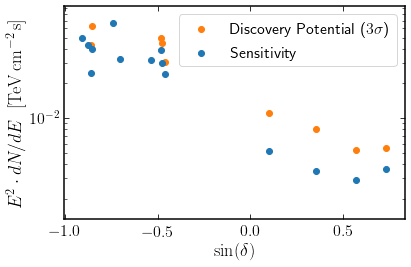

In [21]:
fig, ax = plt.subplots()
# '.-' dot-plus-line style not attractive, but useful for early-stage plotting
ax.scatter(sindecs, fluxs_disc, color='C1', label=r'Discovery Potential ($3\sigma$)')
ax.scatter(sindecs, fluxs_sens, color='C0', label=r'Sensitivity')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2\cdot dN/dE\ \ [\mathrm{TeV}\,\mathrm{cm}^{-2}\,\mathrm{s}]$')
ax.legend()
ax.grid()
ax.set_yscale('log')
plt.tight_layout()

In [6]:
import pickle
with open('/data/user/apizzuto/Nova/csky_trials/nova_2_V959 Mon_delta_t_1.00e+03_minLogE_1.0_gamma_3.0_trials.pkl', 'rb') as f:
    results = pickle.load(f)

In [15]:
results['settings']

Namespace(deltaT=1000.0, disc_CL=0.5, disc_n_sigma=3.0, full_gamma_time=False, index=3.0, minLogE=1.0, nova_num=2, ntrials_bg=1000, ntrials_sig=100)

Text(20,600,'V959 Mon\n$\\delta=6$')

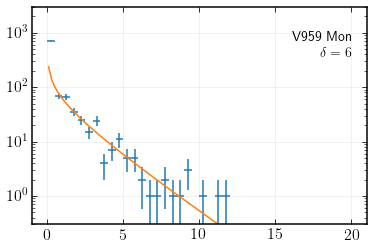

In [19]:
b = results['bg']

fig, ax = plt.subplots()
h = b.get_hist(bins=40, range=(0, 20))
hl.plot1d(ax, h, crosses=True)
# plot chi2 fit to nonzero values
norm = h.integrate().values
ts = np.linspace(.1, h.range[0][1], 100)
ax.plot(ts, norm * b.pdf(ts))
# set limits and label dec
ax.semilogy(nonposy='clip')
ax.set_ylim(.3, 3e3)
ax.text(20, 6e2, results['source_info']['name'].replace('_', ' ').replace(' (', '\n(') + '\n' + r'$\delta={:.0f}$'.format(results['source_info']['dec']*180./np.pi), 
        ha='right', va='center', fontsize=14)

In [36]:
results.keys()

dict_keys(['bg', 'sensitivity', 'discovery', 'fit', 'settings', 'source_info'])

In [248]:
class GammaRayNova():
    r'''Holds information about analysis for 
    individual gamma-ray novae'''
    def __init__(self, name, delta_t, **kwargs):
        self.delta_t = delta_t
        self.name = name
        self.all_flavor = kwargs.pop('allflavor', True)
        self.spec_ind = kwargs.pop('index', [2., 2.5, 3.0])
        if type(self.spec_ind) is float:
            self.spec_ind = [self.spec_ind]
        self.min_log_e = kwargs.pop('min_log_e', 0.)
        self.verbose = kwargs.pop('verbose', False)
        self.trials_base = '/data/user/apizzuto/Nova/csky_trials/'
        try:
            self.sensitivity_trials = {}
            self.discovery_trials = {}
            self.fitting_trials = {}
            for ind in self.spec_ind:
                trials_path = self.trials_base + f'nova_*_{self.name}_delta_t_{self.delta_t:.2e}_minLogE_{self.min_log_e:.1f}_gamma_{ind:.1f}_allflavor_{self.all_flavor}_trials.pkl'
                trials_f = glob(trials_path)[0]
                with open(trials_f, 'rb') as f:
                    nova_trials = pickle.load(f)
                self.sensitivity_trials[ind] = nova_trials['sensitivity']
                self.discovery_trials[ind] = nova_trials['discovery']
                self.fitting_trials[ind] = nova_trials['fit']
            self.background = nova_trials['bg']
            self.ra = nova_trials['source_info']['ra']
            self.dec = nova_trials['source_info']['dec']
        except Exception as e:
            if self.verbose:
                print(f"Could not find trials for Nova {self.name} with analysis details:")
                print(f"\t All flavor: {self.all_flavor}\t Gamma: {self.spec_ind}\t Min log10(E): {self.min_log_e}")
                print(f"\t Duration: {self.delta_t:.2e} s")
        self.fontsize = kwargs.pop('fontsize', 16)
        self.units_ref_str = 'TeV cm^-2 @ 1 TeV'
        self.gamma_colors = {2.0: 'C0', 2.5: 'C1', 3.0: 'C2'}
        self.central_90 = {2.0: (23.26, 4430.12), 2.5: (8.69, 1594.00), 
                           3.0: (4.76, 419.32)}
                
    def background_ts_plot(self, ax=None, label_axes=True, **kwargs):
        r'''Make plot showing chi2 distribution and observed TS
        for background trials'''
        if ax is None:
            fig, ax = plt.subplots()
        bg = self.background
        h = bg.get_hist(bins=40, range=(0, 20))
        hl.plot1d(ax, h, crosses=True)
        norm = h.integrate().values
        ts = np.linspace(.1, h.range[0][1], 100)
        ax.plot(ts, norm * bg.pdf(ts))
        ax.semilogy(nonposy='clip')
        ax.set_ylim(3e-3, bg.n_total*1.5)
        ax.text(20, 6e2, self.name.replace('_', ' ') + '\n' + r'$\delta={:.0f}$'.format(self.dec*180./np.pi), 
                ha='right', va='center', fontsize=self.fontsize)
        if label_axes:
            ax.set_xlabel('TS', fontsize=self.fontsize)
            ax.set_ylabel('Number of Trials', fontsize=self.fontsize)
            
    def ns_fit_bias_plot(self, ax=None, label_axes=True, **kwargs):
        r'''Compare fit and injected number of events'''
        gamma = kwargs.pop('gamma', self.spec_ind[0])
        if ax is None:
            fig, ax = plt.subplots()
        n_sigs = np.unique(self.fitting_trials[gamma].ntrue)
        dns = np.mean(np.diff(n_sigs))
        ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
        h = hl.hist((self.fitting_trials[gamma].ntrue, 
                     self.fitting_trials[gamma].ns), 
                    bins=(ns_bins, 100))
        hl.plot1d(ax, h.contain_project(1), 
                  errorbands=True, drawstyle='default', color=self.gamma_colors[gamma])
        lim = [0., max(n_sigs)+1]
        ax.set_xlim(ax.set_ylim(lim))
        expect_kw = dict(color=self.gamma_colors[gamma], 
                         ls='--', lw=1, zorder=-10)
        ax.plot(lim, lim, **expect_kw)
        if label_axes:
            ax.set_xlabel(r'$n_\mathrm{inj}$', fontsize=self.fontsize)
            ax.set_ylabel(r'$\hat{n_s}$', fontsize=self.fontsize)

    def gamma_fit_bias_plot(self, ax=None, label_axes=True, **kwargs):
        r'''Compare fit spectral indices as a function of signal strength'''
        if ax is None:
            fig, ax = plt.subplots()
        n_sigs = np.unique(self.fitting_trials[self.spec_ind[0]].ntrue)
        dns = np.mean(np.diff(n_sigs))
        ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
        for gamma in self.spec_ind:
            h = hl.hist((self.fitting_trials[gamma].ntrue, 
                         self.fitting_trials[gamma].gamma), 
                        bins=(ns_bins, 100))
            hl.plot1d(ax, h.contain_project(1), errorbands=True, 
                      drawstyle='default', color=self.gamma_colors[gamma])
            expect_kw = dict(color=self.gamma_colors[gamma], 
                         ls='--', lw=1, zorder=-10)
            ax.axhline(gamma, **expect_kw)
        if label_axes:
            ax.set_xlabel(r'$n_\mathrm{inj}$', fontsize=self.fontsize)
            ax.set_ylabel(r'$\hat{\gamma}$', fontsize=self.fontsize)

    def compare_sens_to_photons(self, ax=None, label_axes=True, **kwargs):
        r'''Plot time integrated sensitivities and compare them to 
        the best-fit gamma-ray spectra'''
        gamma_df = pd.read_csv('/home/apizzuto/Nova/gamma_ray_novae.csv')
        try:
            gamma_info = gamma_df.loc[gamma_df['Name'] == self.name]
            gamma = float(gamma_info['Index'])
            integrated_norm = float(gamma_info['Flux'])*1e-7
            cutoff = float(gamma_info['Cutoff'])
        except:
            print(f"Could not find Nova {self.name} in dataframe")
            return
        if ax is None:
            fig, ax = plt.subplots()
        ens = np.logspace(-1., 3., 500)
        photon_norm = self.calc_flux_norm(gamma, cutoff, integrated_norm)
        if np.isinf(cutoff):
            photon_flux = photon_norm * np.power(ens, -gamma)
        else:
            photon_flux = photon_norm * np.power(ens, -gamma) * \
                            np.exp(-ens / cutoff)
        ax.plot(ens, photon_flux* ens**2. * self.delta_t, 
                color=sns.xkcd_rgb['battleship grey'], alpha=0.7)
        
        ######## CONVERT TO NEUTRINO EXPECTATION?
        
        handles = []
        for spec in self.spec_ind:
            nu_sens_spec = np.power(ens, -spec)*self.sensitivity_trials[spec]['E2dNdE']*1e3*(1e-3)**(2.-spec)
            en_msk = (ens > self.central_90[spec][0]) & (ens < self.central_90[spec][1])
            ax.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2,
                   color=self.gamma_colors[spec], lw = 1.0)
            handles.append(Line2D([0], [0], color=self.gamma_colors[spec], 
                                  lw=1.5, label=r"$\gamma = $" + f" {spec:.1f}"))
        ax.loglog()
        ax.set_ylim(1e-3, 3e4)
        ax.set_xlim(1e-1, 1e3)
        if label_axes:
            ax.set_xlabel(r"$E$ (GeV)", fontsize=self.fontsize)
            ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (GeV cm$^{-2}$)", fontsize = self.fontsize)
            
        ax.legend(handles=handles, frameon=False)
        
    def calc_flux_norm(self, gamma, cutoff, norm):
        r'''Fermi fluxes are reported in terms of integral fluxes
        above 100 MeV. Convert them here to the same units used here
        Parameters:
        -----------
            -norm: float, integrated flux above 100 MeV in units of photons per cm^-2 s^-1
        Returns:
        --------
            Flux normalization at 1 GeV in units of GeV^-1 cm^-2 s^1
        '''
        if np.isinf(cutoff):
            denom = 0.1*np.exp(2.30259*gamma) / (-1. + gamma)
        else:
            denom = cutoff ** (1.-gamma)*float(mpmath.gammainc(1.-gamma, 0.1/cutoff))
        return norm / denom

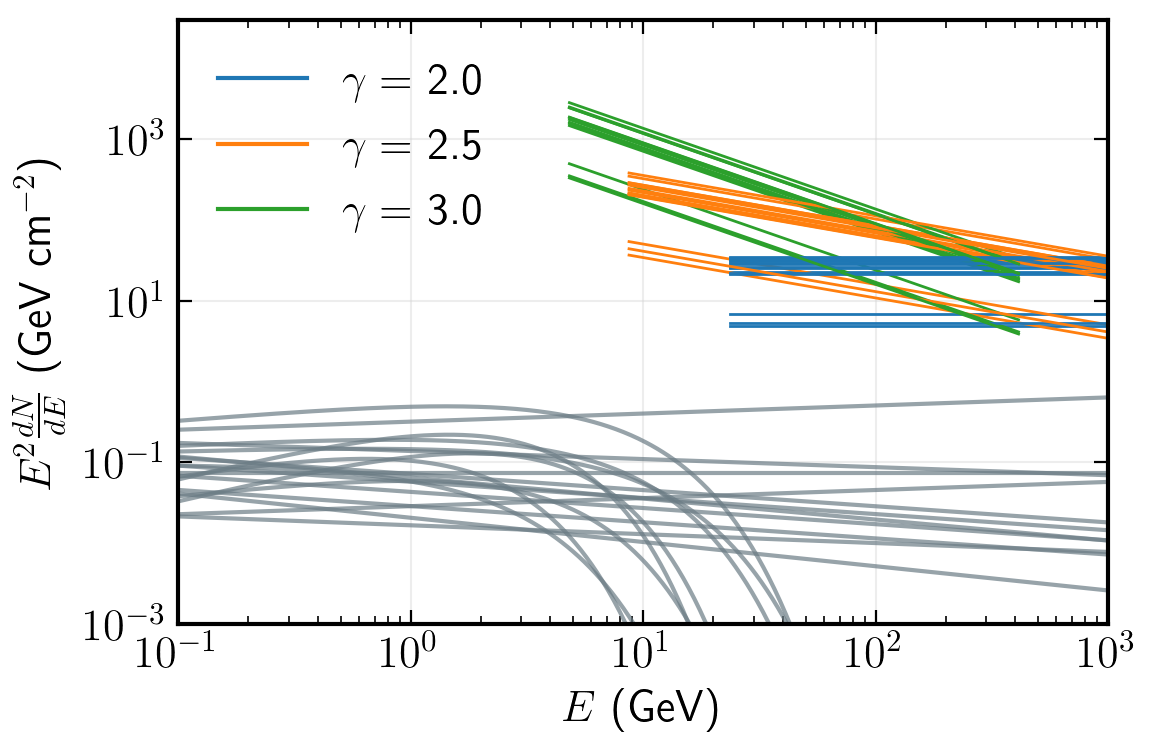

In [249]:
gamma_df = pd.read_csv('/home/apizzuto/Nova/gamma_ray_novae.csv')

fig, ax = plt.subplots(dpi=200)
for name in gamma_df['Name']:
    try:
        nov = GammaRayNova(name, 10.**6.5)
        nov.compare_sens_to_photons(ax=ax)
    except:
        pass

Text(0,0.5,'$E^2 \\frac{dN}{dE}$ (GeV cm$^{-2}$)')

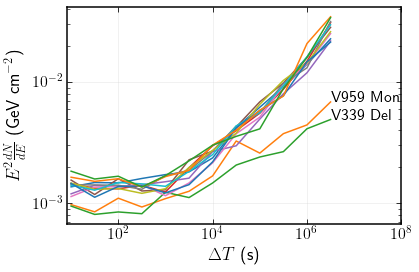

In [254]:
delta_ts = np.logspace(1., 6.5, 12)
sens = {}
for name in gamma_df['Name']:
    sens[name] = {2.: [], 2.5: [], 3.: []}
    for delta_t in delta_ts:
        try:
            nov = GammaRayNova(name, delta_t)
            for spec in nov.spec_ind:
                sens[name][spec].append(nov.sensitivity_trials[spec]['E2dNdE'])
        except:
            break
    sens[name] = {k: np.array(v) for k, v in sens[name].items()}
    
for name in sens.keys():
    try:
        plt.plot(delta_ts, sens[name][2.0])
        if sens[name][2.0][-1] < 1e-2:
            plt.annotate(name, (delta_ts[-1], sens[name][2.0][-1]))
    except:
        pass
    
plt.loglog()
plt.xlim(8e0, 1e8)
plt.xlabel(r"$\Delta T$ (s)")
plt.ylabel(r"$E^2 \frac{dN}{dE}$ (GeV cm$^{-2}$)")
plt.show()

In [250]:
np.log10((gamma_df['Stop Time'] - gamma_df['Start Time']) * 86400.)

0     6.278936
1     6.166963
2     6.278936
3     6.367878
4     6.527578
5     6.676876
6     6.480582
7     5.781612
8     5.890756
9     6.298242
10    4.936514
11    5.538574
12    5.839604
13    6.237544
14    5.781612
15    4.936514
16    6.258733
17    5.538574
18    5.635484
dtype: float64

In [252]:
(10. ** 6.5)/ 86400.

36.60043588157847

In [255]:
np.log10(30. * 86400.)

6.413634997198556

In [223]:
sens

{2.0: [], 2.5: [], 3.0: []}

In [187]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'
mcfiles = glob(greco_base + 'IC86_2012.nu*_with_angErr.npy')
mc = np.load(mcfiles[0])
for flav in mcfiles[1:]:
    mc = np.concatenate((mc, np.load(flav)))

4.762460111070867 419.31873736439945


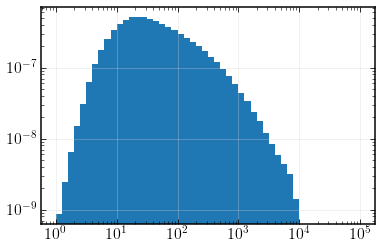

In [200]:
gamma = 3.0
d_omega = 4.*np.pi
e_bins = np.logspace(0., 5., 51)
logE_bins = np.log10(e_bins)
dlog_E = np.diff(logE_bins)
weights = mc['ow'] / (1e4 * mc['trueE'] * dlog_E[np.digitize(np.log10(mc['trueE']), bins = logE_bins) -1] * \
                      d_omega * np.log(10.) / np.power(mc['trueE'], -1*(gamma-1.)))
h = plt.hist(mc['trueE'], bins=e_bins, weights=weights)
plt.loglog()
cdf = np.cumsum(h[0]) / np.sum(h[0])
low_5 = np.interp(0.05, cdf, h[1][:-1])
median = np.interp(0.5, cdf, h[1][:-1])
high_5 = np.interp(0.95, cdf, h[1][:-1])
print(low_5, high_5)

In [197]:
high_5

4430.123303011098

In [106]:
import mpmath

In [ ]:
gamma_df.iloc('Name')

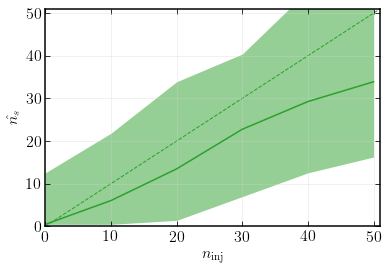

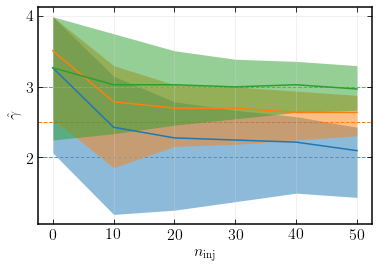

In [62]:
nov = GammaRayNova('V959 Mon', 1e6, verbose=True)
#a = nov.background_ts_plot()
nov.ns_fit_bias_plot(gamma=3.0)
nov.gamma_fit_bias_plot()

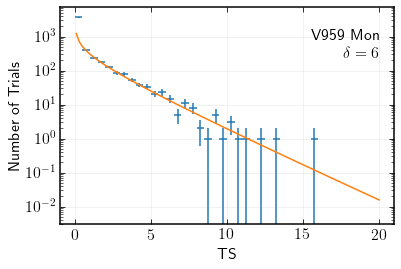

In [21]:
nov = GammaRayNova('V959 Mon', 1e3, verbose=True)
a = nov.background_ts_plot()

In [75]:
np.logspace(1., 6.5, 12)

array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06])